# Skaters (Season 2024/25) - Expected Goals

Definition by Money Puck: "The sum of the probabilities of unblocked shot attempts being goals. For example, a rebound shot in the slot may be worth 0.5 expected goals, while a shot from the blueline while short handed may be worth 0.01 expected goals. The expected value of each shot attempt is calculated by the MoneyPuck Expected Goals model. Expected goals is commonly abbreviated as *xGoals*. Blocked shot attempts are valued at 0 xGoals."

### Import libraries

In [1]:
import sys
import os
import pandas as pd

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
from utils import data_cleaning
from utils import distribution_analysis as da
from utils import continuous_distribution_models as cdm
from utils import feature_engineering
from utils import correlation_analysis
from utils import hypothesis_testing
from utils import regression_analysis

### Import the dataset

In [4]:
#skaters_df = "https://moneypuck.com/moneypuck/playerData/seasonSummary/2024/regular/skaters.csv"
skaters_df = "../data/skaters.csv"
df = pd.read_csv(skaters_df)
df.head(5)

,playerId,season,name,team,position,situation,games_played,icetime,shifts,gameScore,...,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
0,8478047,2024,Michael Bunting,NSH,L,other,76,2237.0,37.0,26.19,...,7.28,10.09,72.0,87.0,0.00,0.00,0.0,0.0,0.0,0.0
1,8478047,2024,Michael Bunting,NSH,L,all,76,70819.0,1474.0,43.70,...,161.54,187.75,3221.0,3522.0,0.00,0.00,0.0,0.0,0.0,0.0
2,8478047,2024,Michael Bunting,NSH,L,5on5,76,59813.0,1294.0,43.70,...,112.73,122.08,2661.0,2707.0,0.71,1.71,19.0,43.0,16.0,31.0
3,8478047,2024,Michael Bunting,NSH,L,4on5,76,6.0,2.0,2.58,...,0.20,0.17,4.0,11.0,0.00,0.00,0.0,0.0,0.0,0.0
4,8478047,2024,Michael Bunting,NSH,L,5on4,76,8763.0,141.0,36.88,...,23.81,2.60,311.0,54.0,0.00,0.01,0.0,1.0,0.0,1.0


### Read the data

In [5]:
data_cleaning.print_df_size(df)

Number of samples: 4600
Number of features: 154


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Columns: 154 entries, playerId to fenwickAgainstAfterShifts
dtypes: float64(147), int64(3), object(4)
memory usage: 5.4+ MB


### Summary Statistics

In [7]:
feature = "I_F_xGoals"

answer = df[df["situation"] == "all"].loc[lambda d: d[feature].idxmax()]
print(f"Most expected goals in all situations: {answer["name"]} with {answer[feature]} goals.")

answer = df[df["situation"] == "5on4"].loc[lambda d: d[feature].idxmax()]
print(f"Most expected goals in 5-on-4 situations: {answer["name"]} with {answer[feature]} goals.")

answer = df[df["situation"] == "4on5"].loc[lambda d: d[feature].idxmax()]
print(f"Most expected goals in 4-on-5 situations: {answer["name"]} with {answer[feature]} goals.")

Most expected goals in all situations: Auston Matthews with 41.05 goals.
Most expected goals in 5-on-4 situations: Jake DeBrusk with 13.26 goals.
Most expected goals in 4-on-5 situations: Seth Jarvis with 2.32 goals.


### Data cleaning

In [8]:
# Missing values?
data_cleaning.report_nan(df)

No missing values found.


In [9]:
df = data_cleaning.drop_duplicate_columns(df)
data_cleaning.save_column_names(df)

Removed duplicate columns: ['I_F_shifts', 'faceoffsWon', 'penalityMinutes']
Number of samples: 4600
Number of features: 151
Saved: names_columns.txt


In [10]:
df_goals = df.drop(["playerId", "season", "name", "team"], axis=1)
data_cleaning.print_df_size(df_goals)

Number of samples: 4600
Number of features: 147


### Variables and Filter

In [11]:
# Filters
situation = "all"
min_games_played = 20

# Variables 
feature="I_F_xGoals"
label="Expected Goals"
label1="Forwards"
label2="Defencemen"

# Reference player
name_player="Auston Matthews"
ref_data = df[(df["name"]==name_player) & (df["situation"]==situation)]

To focus on meaningful performance, this chart includes only skaters who played a minimum number of games.

In [12]:
df_goals = df_goals[(df_goals["situation"] == situation) & (df_goals["games_played"] >= min_games_played)]
df_goals = df_goals.drop(["situation"], axis=1)

df_forwards = df_goals[df_goals["position"]!="D"] # df about forwards

df_dmen = df_goals[df_goals["position"]=="D"] # df about defencemen

## Part 01 - Univariate Analysis

### Grouped Frequency Tables

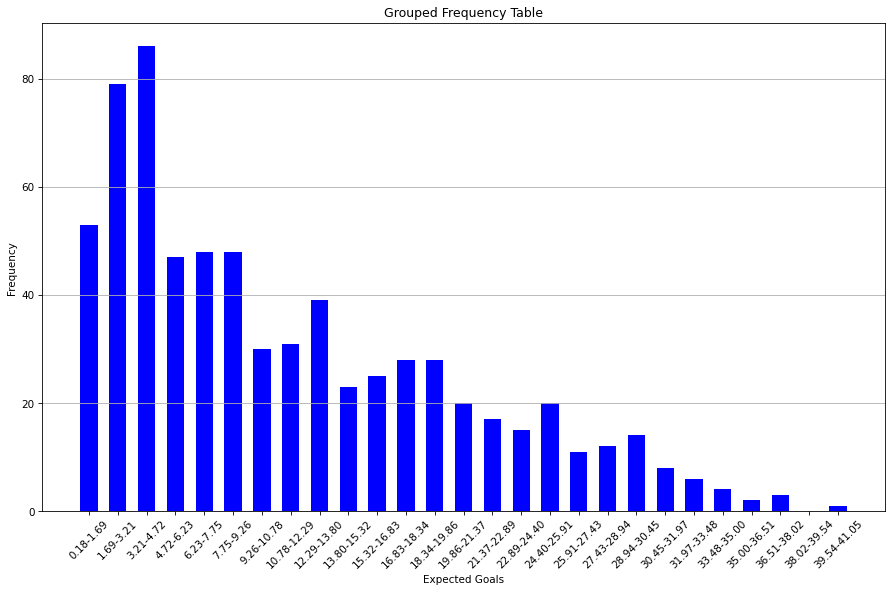

Mean: 11.452
Variance: 80.005
Standard deviation: 8.938
Skewness: 0.835
Kurtosis: 2.786


In [21]:
da.plot_grouped_ftab(df_goals[feature], bin_method="sqrt", xlabel=label)

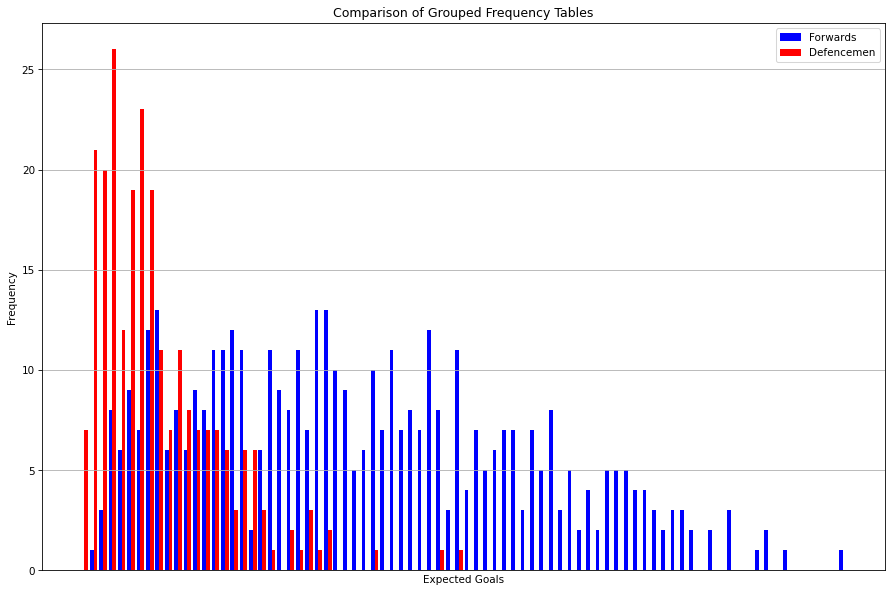

In [14]:
da.plot_two_grouped_ftabs(df_forwards[feature], df_dmen[feature], xlabel=label, label1=label1, label2=label2)

### Cumulative Distribution Function

Auston Matthews - Percentile rank: 100.00
Median: 8.77
Interquartile range: 13.58
Quartile skewness: 0.27


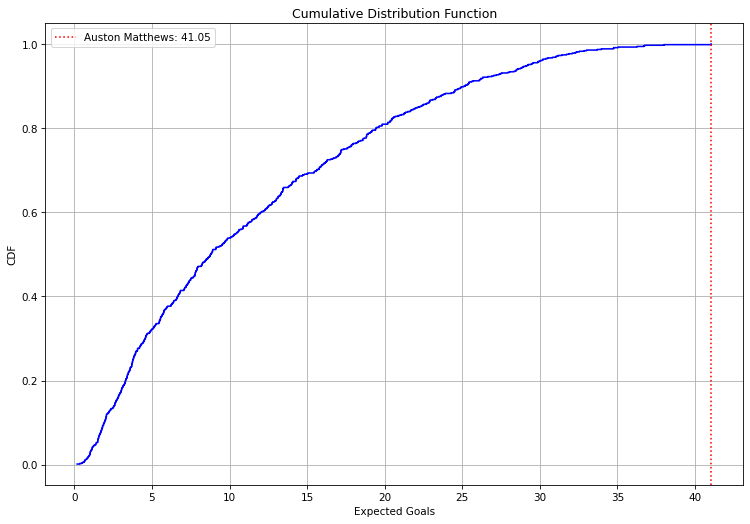

In [15]:
ref = ref_data[feature].values[0]

da.print_percentile_rank(ref, df_goals[feature], label=name_player)
da.plot_cdf(ref, df_goals[feature], label=name_player, xlabel=label)

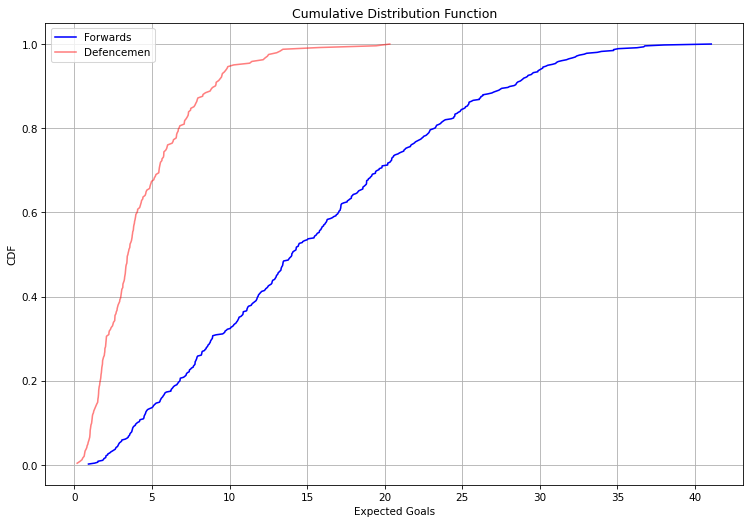

In [16]:
da.plot_two_cdfs(df_forwards[feature], df_dmen[feature], label1=label1, label2=label2, xlabel=label)

### Probability Density Function

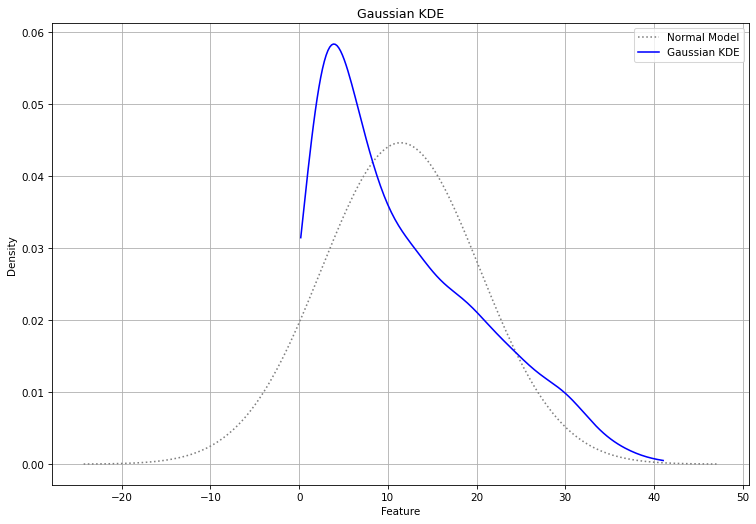

In [17]:
da.plot_gaussian_kde(df_goals[feature])

### Modeling Distributions

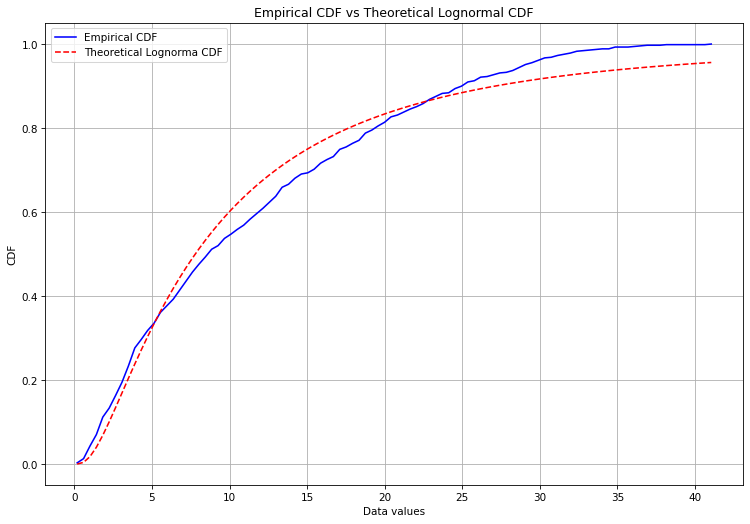

KS test lognorm: stat=0.0761, p-value=0.0006


In [19]:
cdm.plot_empirical_vs_lognorm_cdf(df_goals[feature])
cdm.kolmogorov_smirnov_test(df_goals[feature], "lognorm")

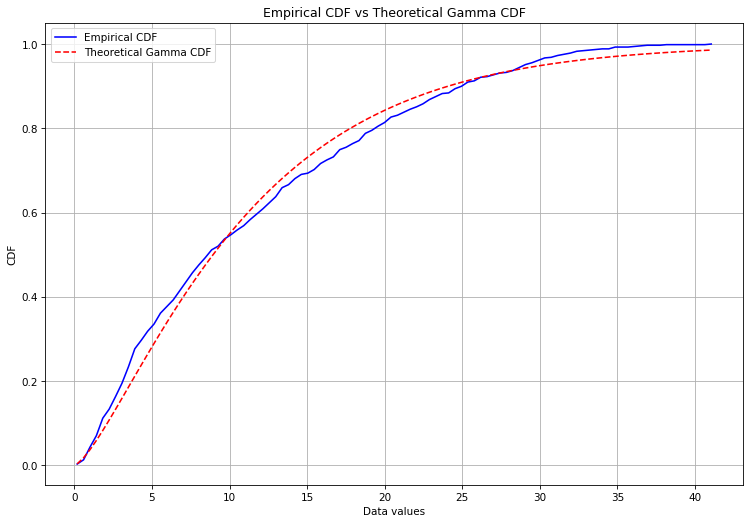

KS test gamma: stat=0.0537, p-value=0.0346


In [20]:
cdm.plot_empirical_vs_gamma_cdf(df_goals[feature])
cdm.kolmogorov_smirnov_test(df_goals[feature], "gamma")

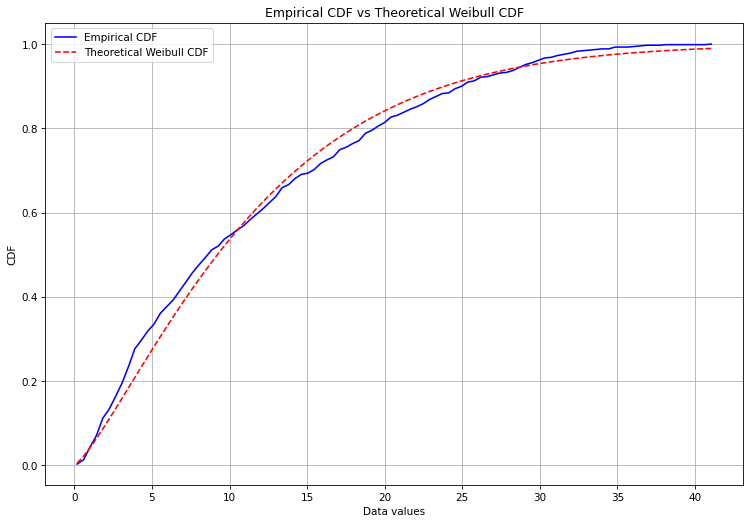

KS test weibull_min: stat=0.0572, p-value=0.0199


In [21]:
cdm.plot_empirical_vs_weibull_cdf(df_goals[feature])
cdm.kolmogorov_smirnov_test(df_goals[feature], "weibull_min")

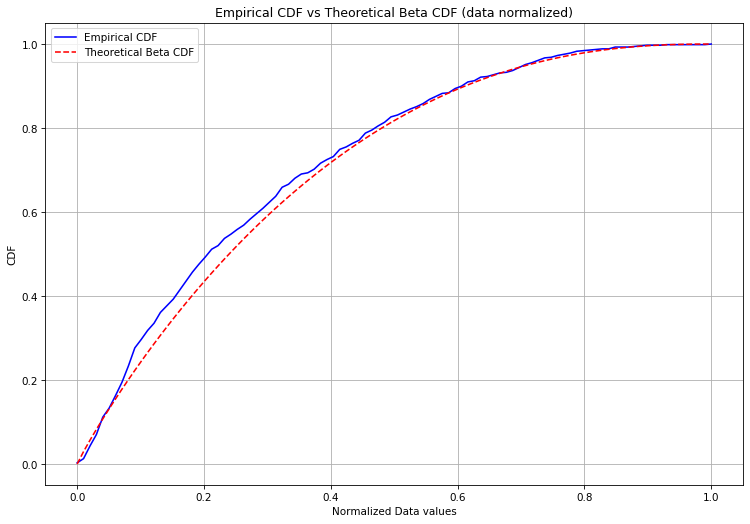

KS test beta: stat=0.0542, p-value=0.0321


In [22]:
cdm.plot_empirical_vs_beta_cdf(df_goals[feature])
cdm.kolmogorov_smirnov_test(df_goals[feature], "beta")

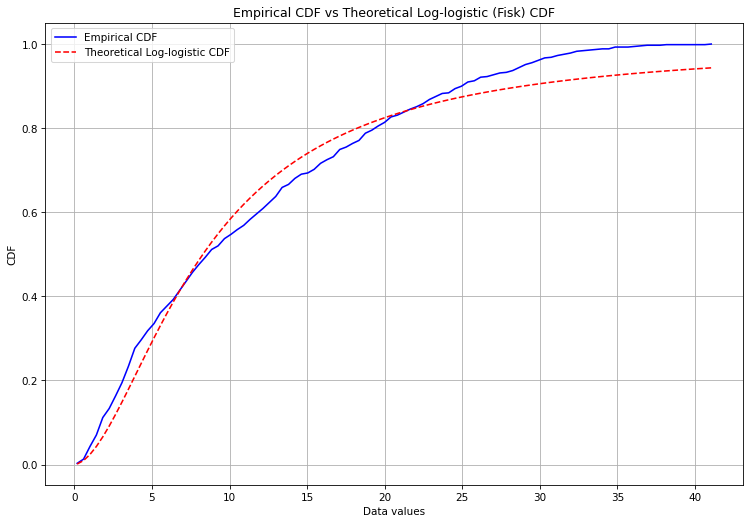

KS test fisk: stat=0.0666, p-value=0.0039


In [23]:
cdm.plot_empirical_vs_loglogistic_cdf(df_goals[feature])
cdm.kolmogorov_smirnov_test(df_goals[feature], "fisk")

### Estimation

### Feature Engineering

In [ ]:
df_goals = feature_engineering.one_hot_encode(df_goals, "position")
df_goals = feature_engineering.one_hot_encode(df_goals, "team")

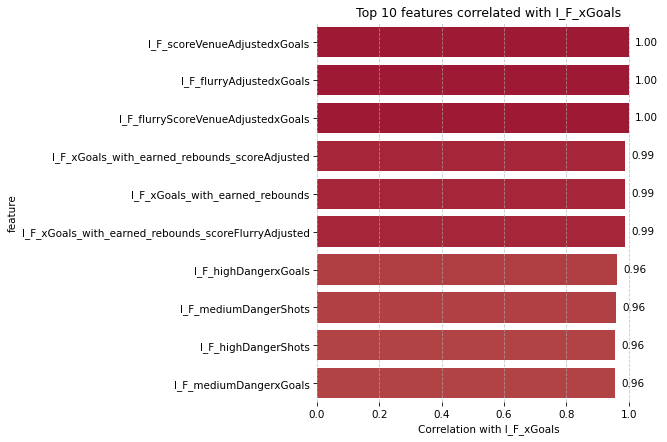

In [24]:
top_corr = correlation_analysis.plot_top_correlations(df_goals, feature)